# Running trVAE on Haber et. al dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import trvae

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


In [3]:
sc.set_figure_params(dpi=200)

## Loading & preparing data

In [4]:
condition_key = "condition"
cell_type_key = "cell_label"

In [5]:
adata = sc.read("/home/mohsen/data/haber/haber_count.h5ad")
adata

AnnData object with n_obs × n_vars = 9842 × 15215 
    obs: 'batch', 'barcode', 'condition', 'cell_label'

## Normalizing & Extracting Top 1000 Highly Variable Genes 
We can preserve more genes (up to 7000 like scGen) but in order to train the network quickly, we will extract top 1000 genes. This can be done with `normalize_hvg` function in the `tl` module of trVAE package. The function accepts the following arguments:

* __adata__: adata containing raw counts in its `.X` attribute.
* __target_sum__: total counts per cell after normalization
* __size_factors__: whether to normalize the `adata` and put total counts per cell in "size_factors" column of `adata.obs` (`True` is recommended).
* __scale_input__: whether to scale the dataset after normalization (`False` is recommended).
* __logtrans_input__: whether to log-transform the `adata` after normalization (`True` is recommended).
* __n_top_genes__: number of highly variable genes to be selected after `adata` normalization.

In [6]:
adata = trvae.tl.normalize_hvg(adata, 
                               target_sum=1e4,
                               size_factors=True, 
                               scale_input=False, 
                               logtrans_input=True, 
                               n_top_genes=1000)
adata

AnnData object with n_obs × n_vars = 9842 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [7]:
adata.X.min(), adata.X.max()

(0.0, 8.656907)

## Original Data UMAP Visualization

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/py

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


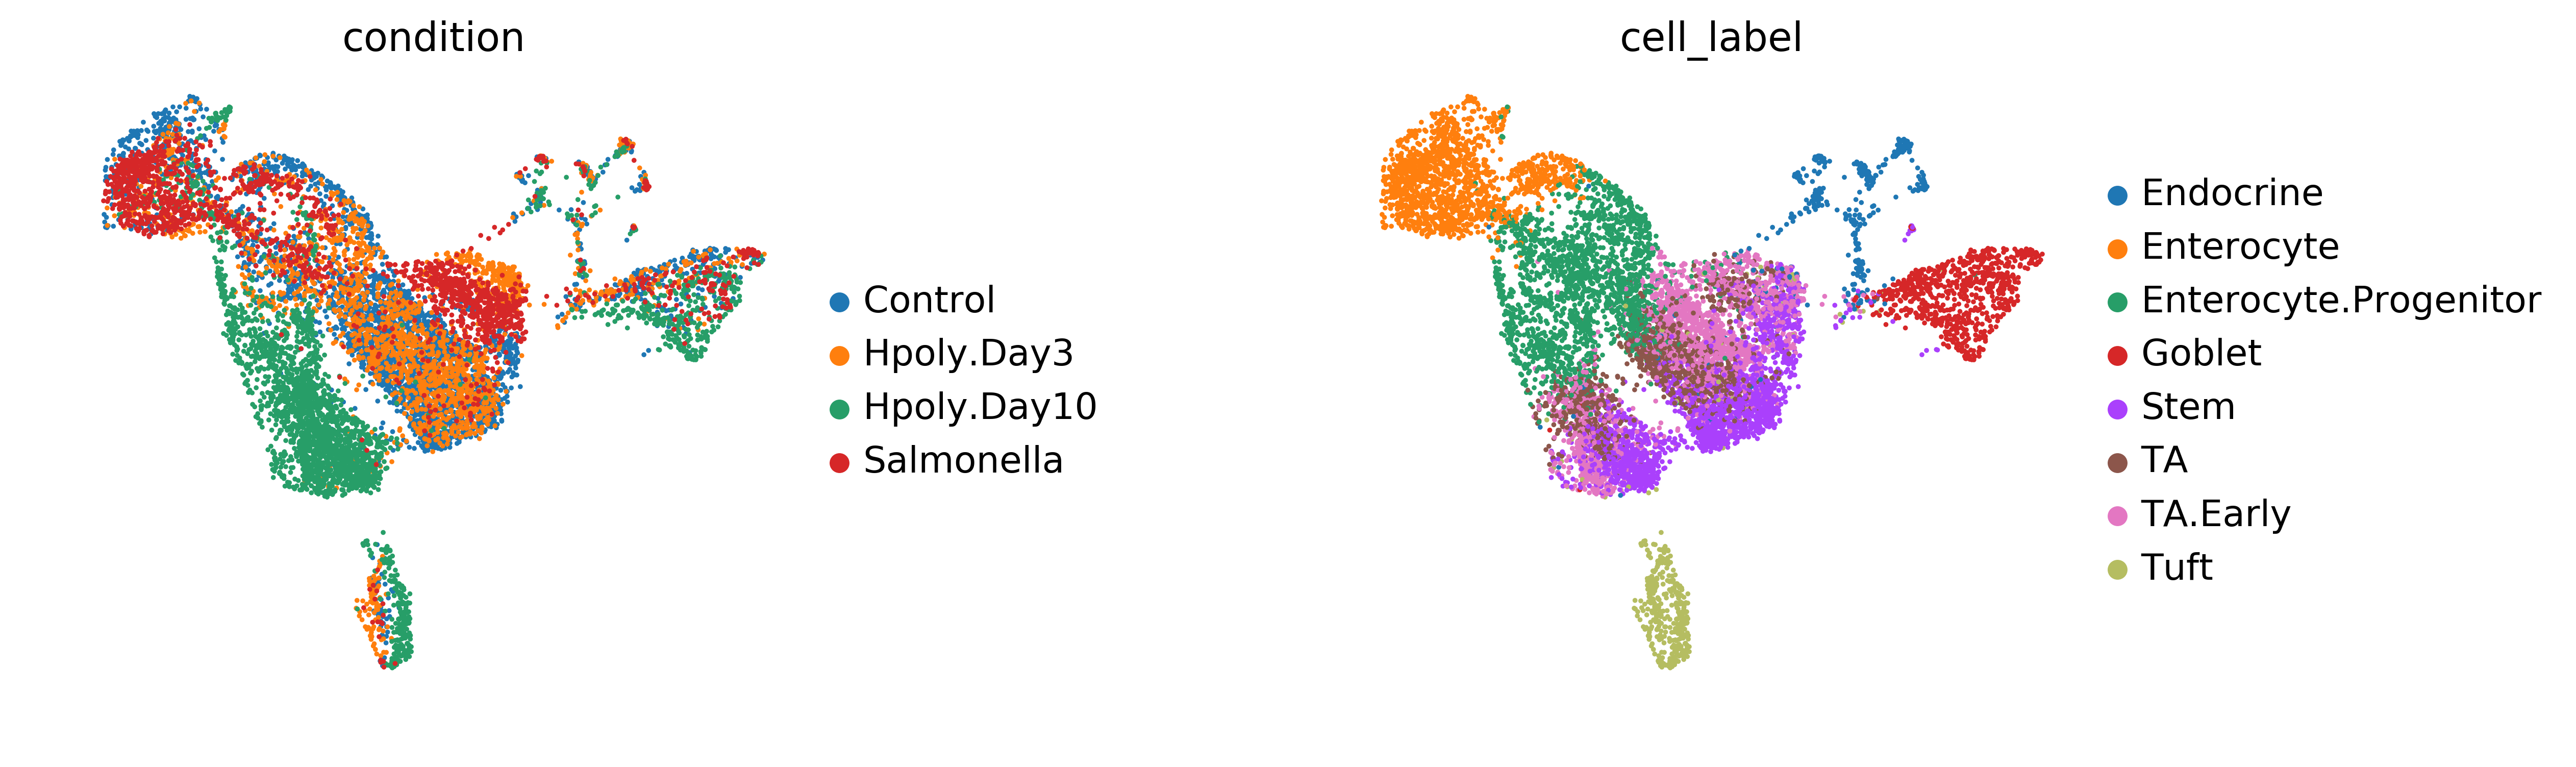

In [9]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

## Calculate number of batches

In [10]:
conditions = adata.obs[condition_key].unique().tolist()

## Create the network
Some of network parameters:
 - __x_dimension__: number of features (necessary)
 - __conditons__: list of unique batches(studies) names
 - __architecture__: architecture of the network (optional)
 - __output_activation__: activation function of trVAE's last layer 
 - __alpha__: coefficient of KL Divergence loss (optional)
 - __beta__: coefficient of MMD loss (optional)
 - __eta__: coefficient of reconstruction (MSE or SSE) loss (optional)
     can be one of the `relu`, `leaky_relu`, `linear`, ... 
 - __gene_names__: list of gene names (`adata.var_names.tolist()`)
 - __loss_fn__: trVAE's loss function (Has to be one of `mse` or `sse`)

In [11]:
network = trvae.models.trVAE(x_dimension=adata.shape[1],
                             architecture=[128, 32],
                             z_dimension=10,
                             gene_names=adata.var_names.tolist(),
                             conditions=conditions,
                             model_path='./models/trVAE/haber/',
                             alpha=0.0001,
                             beta=50,
                             eta=100,
                             loss_fn='mse',
                             output_activation='relu')

W0803 11:18:24.945158 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 11:18:24.947272 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0803 11:18:24.948538 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0803 11:18:26.697491 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

trVAE' network has been successfully constructed!
trVAE'snetwork has been successfully compiled!


## Training trVAE
You can train scArches with train function with the following parameters:

* __adata__: Annotated dataset used for training and evaluating scArches.
* __condition_key__: name of the column in obs matrix in adata which contains the batch_id for each sample.
* __n_epochs__: number of epochs used to train scArches.
* __batch_size__: number of sample used to sample as mini-batches in order to optimize scArches. Please NOTE that for MSE loss with MMD regularization batch sizes upper that 512 is highly recommended
* __save__: whether to save scArches' model and configs after training phase or not.
* __retrain__: if False and scArches' pretrained model exists in model_path, will restore scArches' weights. Otherwise will train and validate scArches on adata.

In [12]:
network.train(adata,
              condition_key,
              train_size=0.8,
              n_epochs=300,
              batch_size=1024,
              early_stop_limit=15,
              lr_reducer=10,
              verbose=5,
              save=True,
              )

W0803 11:19:38.272226 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0803 11:19:38.576020 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0803 11:19:38.927877 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0803 11:19:39.929148 140664611731264 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Plea

 |████████████████████| 100.0%  - loss: 5.9923 - mmd_loss: 0.9889 - reconstruction_loss: 5.0034 - val_loss: 5.6957 - val_mmd_loss: 0.9684 - val_reconstruction_loss: 4.727380

trVAE has been successfully saved in ./models/trVAE/.


## Getting corrected latent adata

Latent space representation of reference data can be computed using `get_latent` function This function has the following parameters:

* __adata__: Annotated dataset to be transformed to latent space
* __batch_key__: Name of the column in obs matrix in adata which contains the study for each sample.

In [13]:
latent_adata = network.get_latent(adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 9842 × 10 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'size_factors'

## UMAP visualization

In [15]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/p

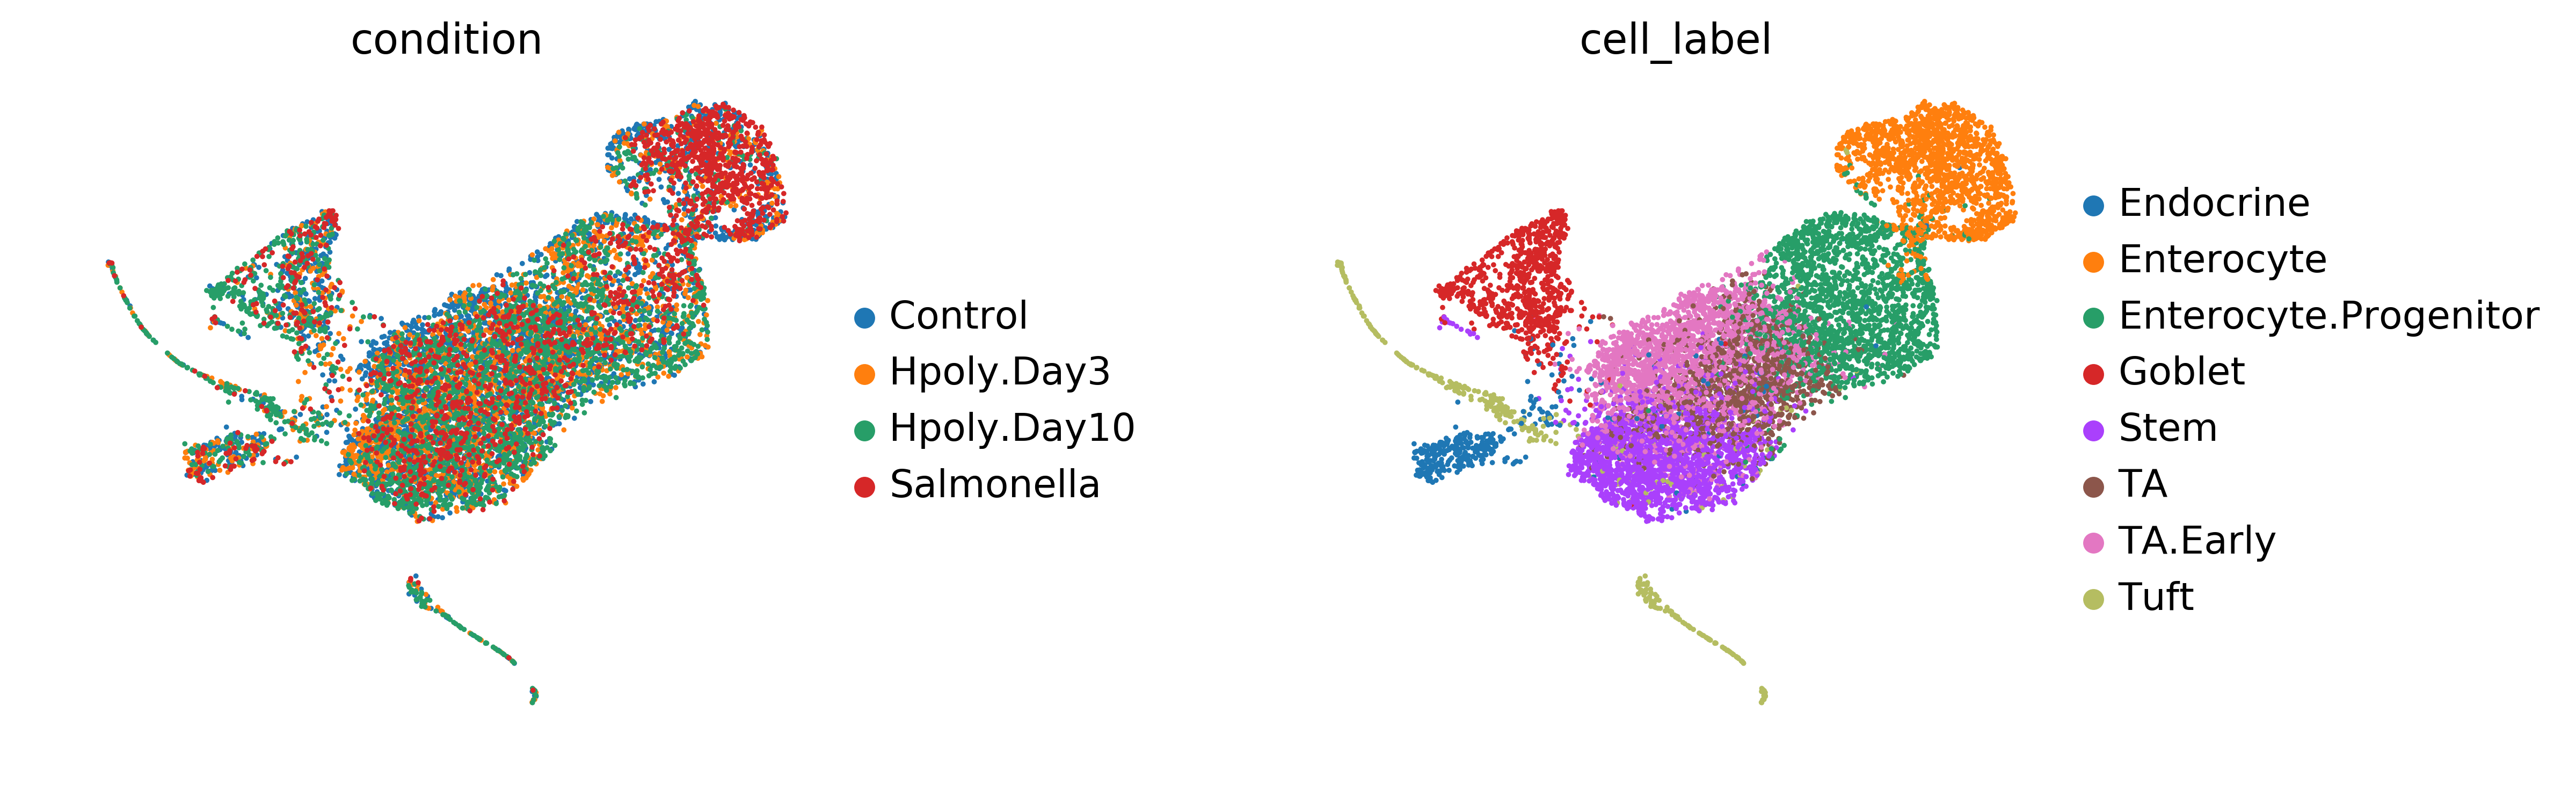

In [17]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)